<a href="https://colab.research.google.com/github/AbdullahHemada/Vision_project/blob/main/5sample_final_ucf101_vision_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import kagglehub
path = kagglehub.dataset_download("matthewjansen/ucf101-action-recognition")

Using Colab cache for faster access to the 'ucf101-action-recognition' dataset.


In [3]:
import os, time, random
import numpy as np
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, TimeDistributed, LSTM, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import optimizers


# Hyperparameter

In [4]:
# -------------------------
# Hyperparameters
# -------------------------
IMG_HEIGHT, IMG_WIDTH = 64, 64
FRAMES_PER_CLIP = 16
MAX_VIDEOS_PER_CLASS = 80
BATCH_SIZE = 4
EPOCHS = 30


In [5]:
# Only use a subset of 5 action classes
ACTION_LABELS = [
    "WalkingWithDog",
    "PushUps",
    "BrushingTeeth",
    "BlowingCandles",
    "Typing"
]

ROOT_DIR = "/kaggle/input/ucf101-action-recognition/"
random.seed(42)
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)


# Helper Functions




In [6]:
# -------------------------
# Helper Functions
# -------------------------

def preprocess_frame(frame):
    """Convert BGR -> RGB, resize, normalize"""
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(rgb_frame, (IMG_WIDTH, IMG_HEIGHT))
    return resized.astype("float32") / 255.0

def video_to_array(video_path, num_frames=FRAMES_PER_CLIP):
    """Load video and return sequence of frames"""
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret: break
        frames.append(frame)
    cap.release()

    if len(frames) == 0: return None

    if len(frames) < num_frames:
        while len(frames) < num_frames:
            frames.append(frames[-1])
        selected = frames
    else:
        idxs = np.linspace(0, len(frames)-1, num_frames).astype(int)
        selected = [frames[i] for i in idxs]

    processed = [preprocess_frame(f) for f in selected]
    return np.array(processed)


# load_action_split
def load_dataset(split="train"):
    """Load all videos and labels from a split folder"""
    X, Y = [], []
    label_map = {label: i for i, label in enumerate(ACTION_LABELS)}

    split_folder = os.path.join(ROOT_DIR, split)
    if not os.path.isdir(split_folder):
        print(f"Split folder {split_folder} not found!")
        return None, None

    for cls in ACTION_LABELS:
        cls_folder = os.path.join(split_folder, cls)
        if not os.path.isdir(cls_folder): continue

        files = [f for f in os.listdir(cls_folder) if f.lower().endswith(('.avi','.mp4'))]
        random.shuffle(files)
        files = files[:MAX_VIDEOS_PER_CLASS]
        print(f"[{split}] Loading {cls}: {len(files)} videos")

        for vid in files:
            arr = video_to_array(os.path.join(cls_folder, vid))
            if arr is None: continue
            X.append(arr)
            Y.append(label_map[cls])

    X_arr = np.array(X)
    Y_arr = to_categorical(np.array(Y), num_classes=len(ACTION_LABELS))
    print(f"Loaded {split}: {X_arr.shape}, {Y_arr.shape}")
    return X_arr, Y_arr


# Load action data (train/val/test) "pre-splited"

In [7]:
print("\n=== Loading Dataset ===")
X_train, y_train = load_dataset("train")
X_val, y_val     = load_dataset("val")
X_test, y_test   = load_dataset("test")



=== Loading Dataset ===
[train] Loading WalkingWithDog: 80 videos
[train] Loading PushUps: 76 videos
[train] Loading BrushingTeeth: 80 videos
[train] Loading BlowingCandles: 80 videos
[train] Loading Typing: 80 videos
Loaded train: (396, 16, 64, 64, 3), (396, 5)
[val] Loading WalkingWithDog: 15 videos
[val] Loading PushUps: 13 videos
[val] Loading BrushingTeeth: 16 videos
[val] Loading BlowingCandles: 14 videos
[val] Loading Typing: 17 videos
Loaded val: (75, 16, 64, 64, 3), (75, 5)
[test] Loading WalkingWithDog: 16 videos
[test] Loading PushUps: 13 videos
[test] Loading BrushingTeeth: 17 videos
[test] Loading BlowingCandles: 14 videos
[test] Loading Typing: 17 videos
Loaded test: (77, 16, 64, 64, 3), (77, 5)


# Model

In [8]:
def create_cnn_lstm_model():
    """CNN (MobileNetV2) + LSTM"""
    base_cnn = MobileNetV2(include_top=False, weights="imagenet",
                           input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    inp = Input(shape=(FRAMES_PER_CLIP, IMG_HEIGHT, IMG_WIDTH, 3))
    x = TimeDistributed(base_cnn)(inp)
    x = TimeDistributed(GlobalAveragePooling2D())(x)
    x = LSTM(128, return_sequences=False)(x)
    x = Dense(128, activation="relu")(x)
    out = Dense(len(ACTION_LABELS), activation="softmax")(x)

    return Model(inputs=inp, outputs=out)

# Training and Optimization

In [9]:
# -------------------------
# Training multiple optimizers
# -------------------------
def train_with_optimizers(X_tr, y_tr, X_vl, y_vl):
    opt_dict = {
        "SGD": optimizers.SGD(learning_rate=3e-4, momentum=0.9),
        "Adam": optimizers.Adam(learning_rate=1e-3),
        "Adagrad": optimizers.Adagrad(learning_rate=1e-3)
    }

    histories = {}
    best_model = None
    best_val_acc = -1
    best_opt_name = ""

    for opt_name, opt in opt_dict.items():
        print(f"\n==== Training with {opt_name} ====")
        model = create_cnn_lstm_model()
        model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

        t0 = time.time()
        hist = model.fit(
            X_tr, y_tr,
            validation_data=(X_vl, y_vl),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            verbose=1
        )
        t1 = time.time()

        histories[opt_name] = {"history": hist.history, "model": model, "time": t1-t0}
        last_val = hist.history["val_accuracy"][-1]
        print(f"{opt_name} last val_acc: {last_val:.4f}")

        if last_val > best_val_acc:
            best_val_acc = last_val
            best_model = model
            best_opt_name = opt_name

    print(f"\nBest optimizer: {best_opt_name} with val_acc: {best_val_acc:.4f}")
    return best_model, histories

# Plotting Training Curves for Optimizer Comparison¶

In [10]:
# -------------------------
# Train and compare optimizers
# -------------------------
best_model, all_histories = train_with_optimizers(X_train, y_train, X_val, y_val)


# -------------------------
# Evaluate on test set
# -------------------------
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")



==== Training with SGD ====


/tmp/ipython-input-2663200815.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_cnn = MobileNetV2(include_top=False, weights="imagenet",


Epoch 1/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 210s 508ms/step - accuracy: 0.2253 - loss: 1.6062 - val_accuracy: 0.3600 - val_loss: 1.5306
Epoch 2/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 30s 300ms/step - accuracy: 0.5828 - loss: 1.3602 - val_accuracy: 0.5067 - val_loss: 1.3183
Epoch 3/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 29s 296ms/step - accuracy: 0.6263 - loss: 1.1622 - val_accuracy: 0.7333 - val_loss: 1.1331
Epoch 4/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 30s 301ms/step - accuracy: 0.7219 - loss: 0.9058 - val_accuracy: 0.7333 - val_loss: 0.9506
Epoch 5/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 29s 295ms/step - accuracy: 0.8223 - loss: 0.6641 - val_accuracy: 0.7867 - val_loss: 0.7477
Epoch 6/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 30s 299ms/step - accuracy: 0.9068 - loss: 0.4656 - val_accuracy: 0.8133 - val_loss: 0.6589
Epoch 7/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 29s 296ms/step - accuracy: 0.9408 - loss: 0.3072 - val_accuracy: 0.8533 - val_loss: 0.5744
Epoch 8/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 30s 299ms/step - accuracy: 0.9691 - loss: 0.1909 - val_acc

# Plotting Training Curves for Optimizer Comparison

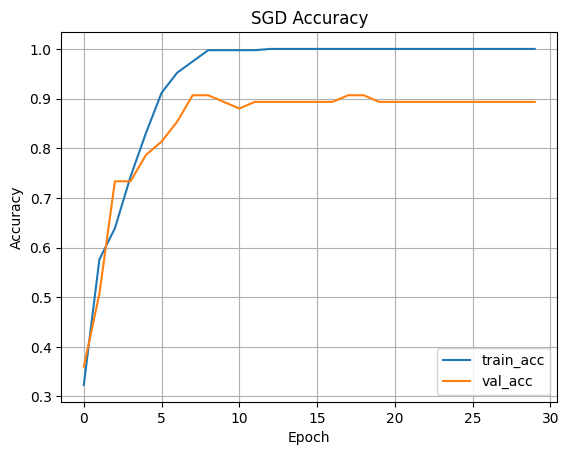

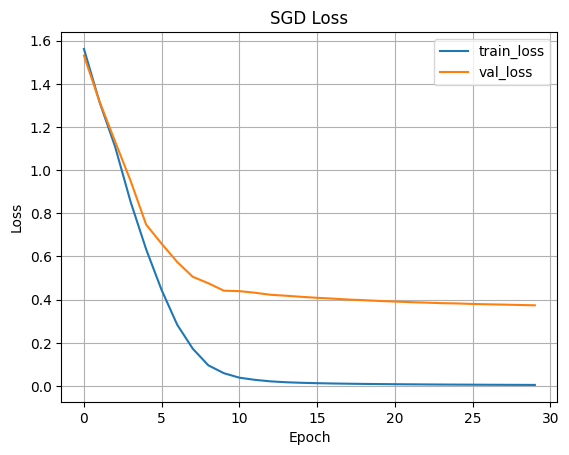

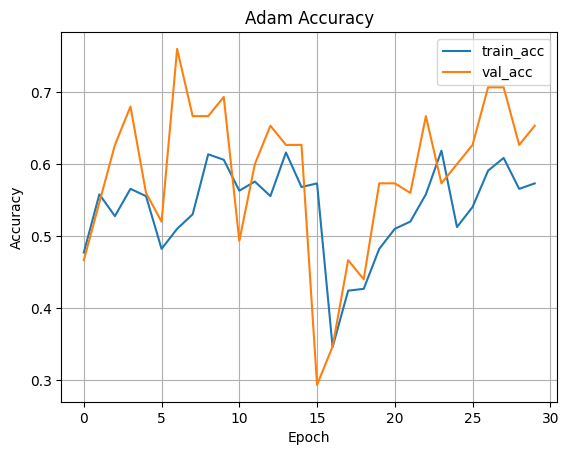

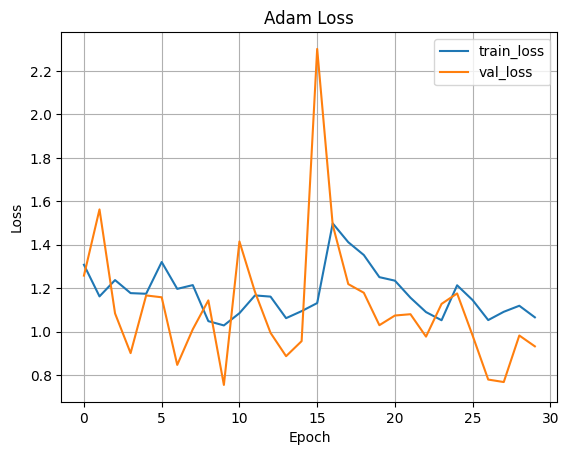

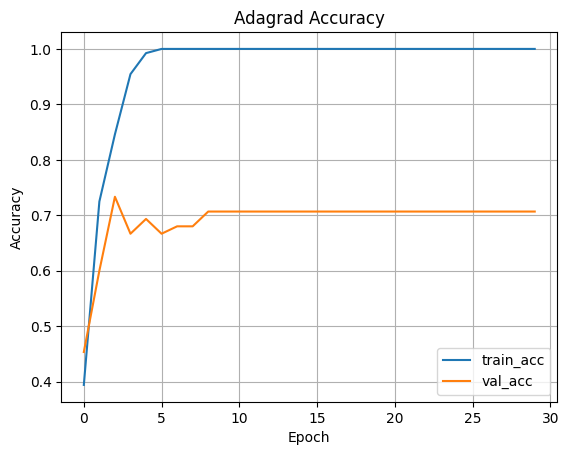

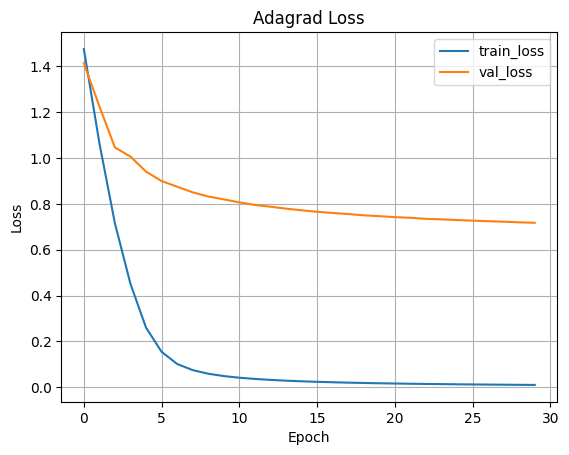

In [12]:
#  -------------------------
# Plot training curves
# -------------------------
def plot_histories(histories):
    for opt_name, info in histories.items():
        hist = info["history"]
        plt.figure()
        plt.plot(hist["accuracy"], label="train_acc")
        plt.plot(hist["val_accuracy"], label="val_acc")
        plt.title(f"{opt_name} Accuracy")
        plt.xlabel("Epoch"); plt.ylabel("Accuracy")
        plt.grid(True); plt.legend()

        plt.figure()
        plt.plot(hist["loss"], label="train_loss")
        plt.plot(hist["val_loss"], label="val_loss")
        plt.title(f"{opt_name} Loss")
        plt.xlabel("Epoch"); plt.ylabel("Loss")
        plt.grid(True); plt.legend()

plot_histories(all_histories)

# Model Testing & Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
==== Random Test Video ====
True Label: WalkingWithDog
Pred Label: WalkingWithDog


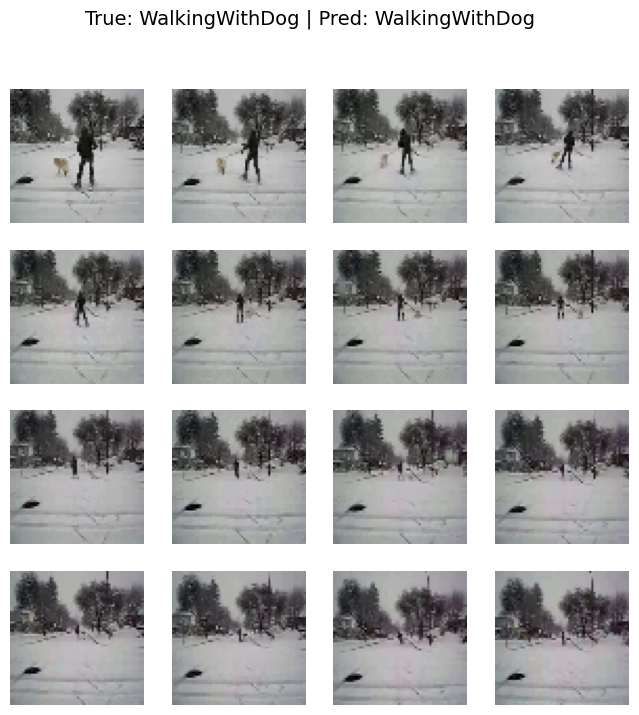

In [14]:
# -------------------------
# Test random video visualization
# -------------------------
def visualize_random_test(model, X_te, y_te, class_names):
    idx = random.randint(0, len(X_te)-1)
    video = X_te[idx]
    true_lbl = np.argmax(y_te[idx])

    pred_prob = model.predict(video[np.newaxis,...])[0]
    pred_lbl = np.argmax(pred_prob)

    print("==== Random Test Video ====")
    print("True Label:", class_names[true_lbl])
    print("Pred Label:", class_names[pred_lbl])

    plt.figure(figsize=(8,8))
    for i in range(FRAMES_PER_CLIP):
        plt.subplot(4,4,i+1)
        plt.imshow(video[i])
        plt.axis("off")
    plt.suptitle(f"True: {class_names[true_lbl]} | Pred: {class_names[pred_lbl]}", fontsize=14)
    plt.show()

visualize_random_test(best_model, X_test, y_test, ACTION_LABELS)